Install Dependencies (Colab only)

In [149]:
!pip install virtualenv
!virtualenv venv
!source venv/bin/activate
!pip install numpy
!pip install librosa
!pip install soundfile
!pip install audiomentations
!pip install pydub
!pip install ipython
!pip install matplotlib
!pip install pesq

usage: virtualenv [--version] [--with-traceback] [-v | -q] [--read-only-app-data] [--app-data APP_DATA] [--reset-app-data] [--upgrade-embed-wheels] [--discovery {builtin}] [-p py] [--try-first-with py_exe]
                  [--creator {builtin,cpython3-posix,venv}] [--seeder {app-data,pip}] [--no-seed] [--activators comma_sep_list] [--clear] [--no-vcs-ignore] [--system-site-packages] [--symlinks | --copies] [--no-download | --download]
                  [--extra-search-dir d [d ...]] [--pip version] [--setuptools version] [--wheel version] [--no-pip] [--no-setuptools] [--no-wheel] [--no-periodic-update] [--symlink-app-data] [--prompt prompt] [-h]
                  dest
virtualenv: error: the following arguments are required: dest
SystemExit: 2
/bin/bash: line 1: venv/bin/activate: No such file or directory


Mount Google Drive to load audio files (Colab only)

In [150]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries

In [1]:
import os
import random
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from audiomentations import Compose, AddBackgroundNoise, AddColorNoise, AddGaussianNoise, BandPassFilter, Resample, Mp3Compression

Path to speech files and folders in the drive (Change these patterns if using the notebook locally)

In [205]:
clean_audio_folder_path = '/content/drive/My Drive/Telephaty_challenge/tl_speech_challenge/clean_speech'
augmented_audio_folder_path = '/content/drive/My Drive/Telephaty_challenge/tl_speech_challenge/augmented_speech'
enviroment_noises_folder_path = '/content/drive/My Drive/Telephaty_challenge/tl_speech_challenge/noises/noise'

Visualize input clead speech data

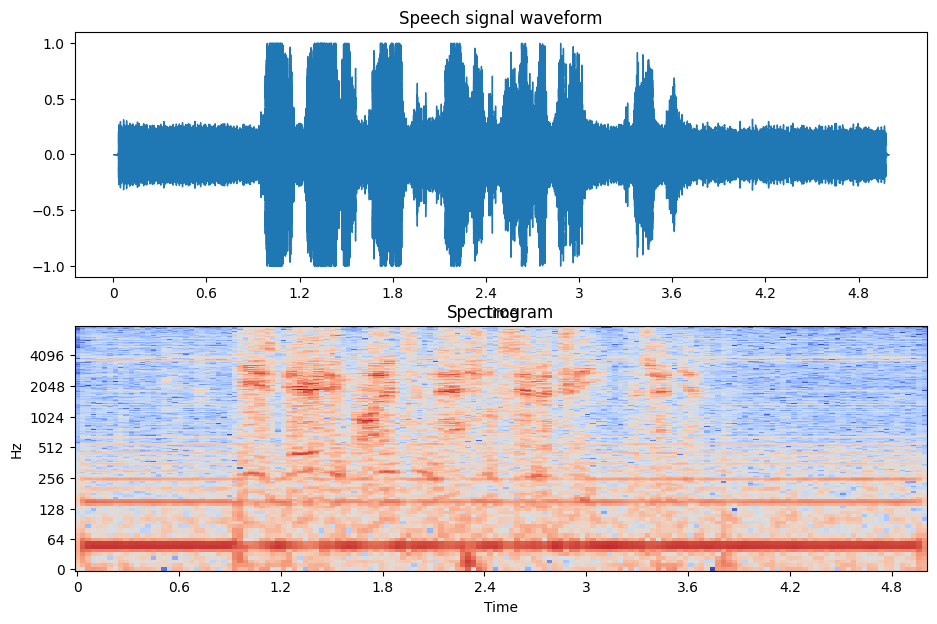


 The audio file is mono. Sample Frequency is: 16000 



In [206]:
"""
Function that visualize waveform and stft on the input signal and return num of channels and SR
"""
def plot_signal(signal, sr):
    fig, ax = plt.subplots(nrows=2, figsize=(11, 7))
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title="Speech signal waveform")
    D = librosa.stft(signal)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm',ax=ax[1])
    ax[1].set(title="Spectrogram")
    plt.show()
    #check dimensionality
    # Check if the audio is mono or stereo
    if signal.ndim == 1:
      return f"The audio file is mono. Sample Frequency is: {sr}"
    elif signal.ndim == 2:
      return f"The audio file is stereo. Sample Frequency is: {sr}"
    else:
      return "The audio file has an unexpected number of channels."


#Specify the file name to visualize and listen
file_name = "common_voice_en_18847010.wav"
file_path = os.path.join(clean_audio_folder_path, file_name)
speech_data, sr = librosa.load(file_path, sr=None)
signal_info = plot_signal(speech_data, sr)
print('\n',signal_info, '\n')
Audio(file_path)



Prepare the train dataset: read, process and save augmented speech Data

In [234]:
#parameters to controll data augmentaion. You can play with these values. For more informations, check audiomentations Doc
#there are 3 different types of type_of_augmentation chains: augment_raw_audio_noise, augment_raw_audio_tel_channel, augment_raw_audio_noise+tel_channel
type_of_augmentation = "augment_raw_audio_noise+tel_channel"
#first chain parameters
gaussian_noise_factor = 0.010 #Maximum noise amplification factor for gaussian noise. Min is 0.001
env_noise_max_snr = 25.0  #Maximum signal-to-noise ratio in dB
#second chain parameters
min_bitrate = 8
max_bitrate = 64

#utility function to pick up a random noise among all the possibile availables
def pick_random_file(folder_path):
    # List all files in the specified folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    # Check if the folder is empty
    if not files:
        print("No files found in the specified folder.")
        return None
    # Randomly select a file
    random_file = random.choice(files)
    # Return the full path to the selected file
    return os.path.join(folder_path, random_file)

In [208]:
#function to be called to apply the various augmentation chains
def apply_augmentation(signal, sr, type_of_augmentation, enviroment_noises_folder_path, gaussian_noise_factor, env_noise_max_snr, min_bitrate, max_bitrate):

  if type_of_augmentation == "augment_raw_audio_noise":
    print("Applying augment_raw_audio_noise augmentation chain")
    #audio augmentation object that add noise to the clean speech
    #pick a random enviromental noise from the folder to add it to the clean audio
    env_noise_path = pick_random_file(enviroment_noises_folder_path)
    augment_raw_audio_noise = Compose([
        #background noise with gaussian distribution
        AddGaussianNoise(min_amplitude=0.01, max_amplitude=gaussian_noise_factor, p=1),
        #add background noises from provided files
        AddBackgroundNoise(sounds_path=env_noise_path,
          min_snr_db=10.0,
          max_snr_db=env_noise_max_snr,
          p=1.0)
    ])
    augmented_signal = augment_raw_audio_noise(signal, sr)
    return augmented_signal

  elif type_of_augmentation == "augment_raw_audio_tel_channel":
    print("Applying augment_raw_audio_tel_channel augmentation chain")
    #audio augmentation object that filter the signal into the telephny channel frequency range
    augment_raw_audio_noise = Compose([
        #reduce quality of the audio with mp3 compression
        Mp3Compression(min_bitrate=min_bitrate , max_bitrate=max_bitrate , p=1),
        #band pass filtering to simulate the telephony channel
        BandPassFilter(min_center_freq=200 ,max_center_freq=2000 , min_bandwidth_fraction=0.6 , max_bandwidth_fraction=1.2 )
    ])
    augmented_signal = augment_raw_audio_noise(signal, sr)
    return augmented_signal

  elif type_of_augmentation == "augment_raw_audio_noise+tel_channel":
    print("Applying augment_raw_audio_noise+tel_channel augmentation chain")
    #audio augmentation object that combines previous two transformations
    #pick a random enviromental noise from the folder to add it to the clean audio
    env_noise_path = pick_random_file(enviroment_noises_folder_path)
    #audio augmentation object that add noise to the clean speech
    augment_raw_audio_noise = Compose([
        #background noise with gaussian distribution
        AddGaussianNoise(min_amplitude=0.01, max_amplitude=gaussian_noise_factor, p=1),
        #add background noises from provided files
        AddBackgroundNoise(sounds_path=env_noise_path,
          min_snr_db=3.0,
          max_snr_db=env_noise_max_snr,
          p=1.0),
        Mp3Compression(min_bitrate=min_bitrate , max_bitrate=max_bitrate , p=1),
        BandPassFilter(min_center_freq=200 ,max_center_freq=2000 , min_bandwidth_fraction=0.6 , max_bandwidth_fraction=1.2 )
    ])
    augmented_signal = augment_raw_audio_noise(signal, sr)
    return augmented_signal

  #return augmented signal
  return augmented_signal

Cell that runs the augmentation

In [235]:

for filename in os.listdir(clean_audio_folder_path):
  if filename.endswith('.wav'):
    file_path = os.path.join(clean_audio_folder_path, filename)

    # Load the audio file with librosa
    clean_speech_signal, sr = librosa.load(file_path, sr=None)

    #apply transformations to augment this audio file
    print(f"Input clean speech file: {file_path}")
    augmented_audio =  apply_augmentation(clean_speech_signal, sr, type_of_augmentation, enviroment_noises_folder_path, gaussian_noise_factor, env_noise_max_snr, min_bitrate, max_bitrate)

    #save the augmented audio file on the disk
    subfolder_path = os.path.join(augmented_audio_folder_path, type_of_augmentation)
    # Ensure the subfolder exists
    os.makedirs(subfolder_path, exist_ok=True)
    output_file_path = os.path.join(subfolder_path, filename)
    sf.write(output_file_path, augmented_audio, sr)
    print(f"Input clean speech file: {output_file_path}", '\n')


Input clean speech file: /content/drive/My Drive/Telephaty_challenge/tl_speech_challenge/clean_speech/common_voice_en_18707271.wav
Applying augment_raw_audio_noise+tel_channel augmentation chain
Input clean speech file: /content/drive/My Drive/Telephaty_challenge/tl_speech_challenge/augmented_speech/augment_raw_audio_noise+tel_channel/common_voice_en_18707271.wav 

Input clean speech file: /content/drive/My Drive/Telephaty_challenge/tl_speech_challenge/clean_speech/common_voice_en_26986908.wav
Applying augment_raw_audio_noise+tel_channel augmentation chain
Input clean speech file: /content/drive/My Drive/Telephaty_challenge/tl_speech_challenge/augmented_speech/augment_raw_audio_noise+tel_channel/common_voice_en_26986908.wav 

Input clean speech file: /content/drive/My Drive/Telephaty_challenge/tl_speech_challenge/clean_speech/common_voice_en_18847010.wav
Applying augment_raw_audio_noise+tel_channel augmentation chain
Input clean speech file: /content/drive/My Drive/Telephaty_challenge/

Comparison of Clean and Augmented Speech

In [160]:
"""
Function that compare waveforms of the clean and augmented signal
"""
def plot_waveform_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2, figsize=(11, 7))
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title="Original signal")
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title="Augmented signal")
    plt.show()

"""
Function that compare STFT of the clean and augmented signal
"""
def plot_stft_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2, figsize=(11, 7))
    D = librosa.stft(signal)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm',ax=ax[0])
    ax[0].set(title="Spectrogram Original signal")
    D = librosa.stft(augmented_signal)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm',ax=ax[1])
    ax[1].set(title="Spectrogram AUgmented Signal")
    plt.show()

In [251]:
#Use these fucntions to show some examples. Specify clean file name and the augmentation pipeline to compare
file_name = "common_voice_en_25230829.wav"
type_of_augmentation = "augment_raw_audio_tel_channel"
clean_file_path = os.path.join(clean_audio_folder_path, file_name)
augmented_file_path =  os.path.join(augmented_audio_folder_path, type_of_augmentation, file_name)
clean_signal, sr_clean =  librosa.load(clean_file_path, sr=None)
augmented_signal, sr_aug = librosa.load(augmented_file_path, sr=None)

#check SR
if sr_clean != sr_aug:
  print("different SR")

#listen two audio files
print("Clean original audio")
Audio(clean_file_path)


Clean original audio


In [252]:
print("Augmented audio")
Audio(augmented_file_path)

Augmented audio


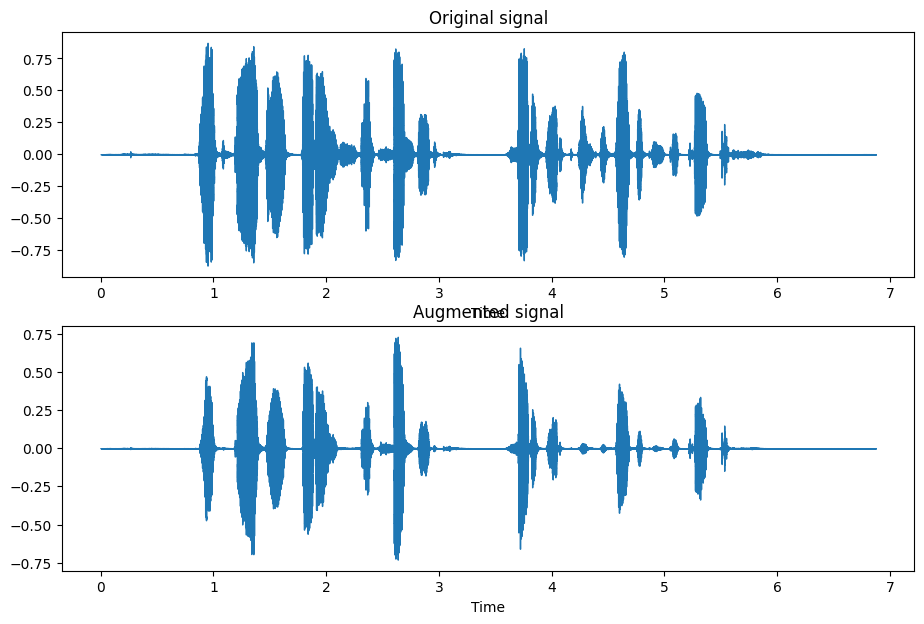

In [258]:
#compare waveforms: clean vs augmented
plot_waveform_signal_and_augmented_signal(clean_signal, augmented_signal, sr_clean)

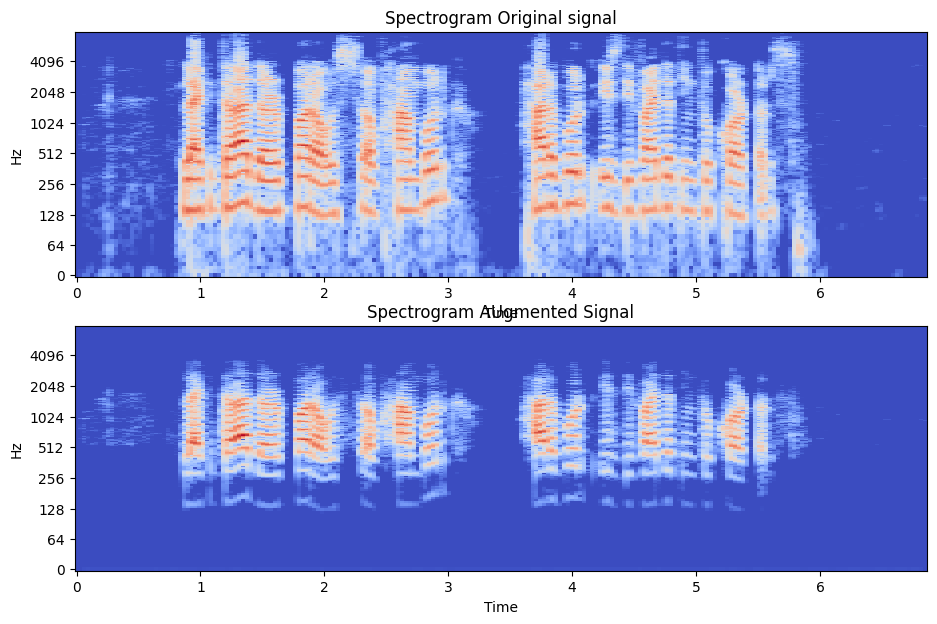

In [259]:
#compare spectrograms: clean vs augmented
plot_stft_signal_and_augmented_signal(clean_signal, augmented_signal, sr_clean)

Comparing Signal-to-Noise-Ratio

In [260]:
#SNR definition
def compute_snr(clean_signal, augmented_signal):
    noise = clean_signal - augmented_signal
    snr = 10 * np.log10(np.sum(clean_signal**2) / np.sum(noise**2))
    return snr

snr_value = compute_snr(clean_signal, augmented_signal)
print(f"SNR value for this couple of speech files: {snr_value} DB")

SNR value for this couple of speech files: -1.7485560476779938 DB


Other possibile quantitave comparisons: STOI (Short Term Objective Intelligibility), PESQ (Perceptual Evaluation of Speech Quality) to decide how much noise adding to the input clean speech